# Predicción éxito artitas musicales

Dado un conjunto de presentaciones hechas por distintos artistas + el porcentaje de tickets vendidos por cada uno en cada presentación se va a intentar contruir un modelo que permita predecir el éxito del evento (porcentaje de tickets) dada las siguientes caracteristicas:

1. dayofweek	
2. state_pob	
3. capacity	
4. price	
5. facebook_likes	
6. youtube_suscrs	
7. youtube_views	
8. instagram_folls	
9. instagram_likes	
10. spotify_folls	
11. spotify_pop	
12. twitter_folls	
13. twitter_mencs_usa	
14. twitter_mencs	
15. facebook_crec	
16. youtube_crec	
17. instagram_crec	
18. twitter_crec

caracteristica a predecir: tickets


# Metodología
1. Carga de datos
2. Analisis exploratorio (distintas visualizaciones).
3. Evaluaciones de distintos modelos de regresion basados en redes neuronales. (GridSearchCV con k-fold)
4. Evaluacion de mejor modelo de redes neuronales con lasso. (k-fold)
5. Test de significancia estadistica.
6. Correlación salida real v/s la predicha por el mejor modelo

## 1.- Carga de datos

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./rrss_final.csv")
# Muestra las 5 primeras filas
#hay algunos NaN
df = df.fillna(0)
df.head()

,name,dayofweek,state_pob,capacity,price,facebook_likes,youtube_suscrs,youtube_views,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
0,10000 maniacs,2,18801310,896,32.5,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,100
1,10000 maniacs,3,18801310,464,57.0,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,70
2,5 seconds of summer,6,6547629,953,29.5,220997,5198269,145192066,7400000,36753,3268169.0,84.0,12503006,430,1000,-5.121,0.271,0.000,0.063,100
3,aaron lewis,2,6483802,1417,52.5,794140,249144,114306783,131300,30825,184851.0,57.0,88664,52,58,1.916,1.443,0.458,0.082,98
4,aaron watson,4,38332521,1000,10.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,67


transformación de la variable categórica: dìa de la semana

In [3]:
dummies = pd.get_dummies(df['dayofweek'], prefix = 'dayofweek')
data = pd.concat([dummies, df], axis=1)
data = data.drop(['dayofweek', 'name'], axis=1)
data.head()

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,state_pob,capacity,price,...,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
0,0,0,1,0,0,0,0,18801310,896,32.5,...,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,100
1,0,0,0,1,0,0,0,18801310,464,57.0,...,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,70
2,0,0,0,0,0,0,1,6547629,953,29.5,...,3268169.0,84.0,12503006,430,1000,-5.121,0.271,0.000,0.063,100
3,0,0,1,0,0,0,0,6483802,1417,52.5,...,184851.0,57.0,88664,52,58,1.916,1.443,0.458,0.082,98
4,0,0,0,0,1,0,0,38332521,1000,10.0,...,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,67


## 2.- Análisis exploratorio

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### 2.1 - Toda las caracteristivas v/s tickets

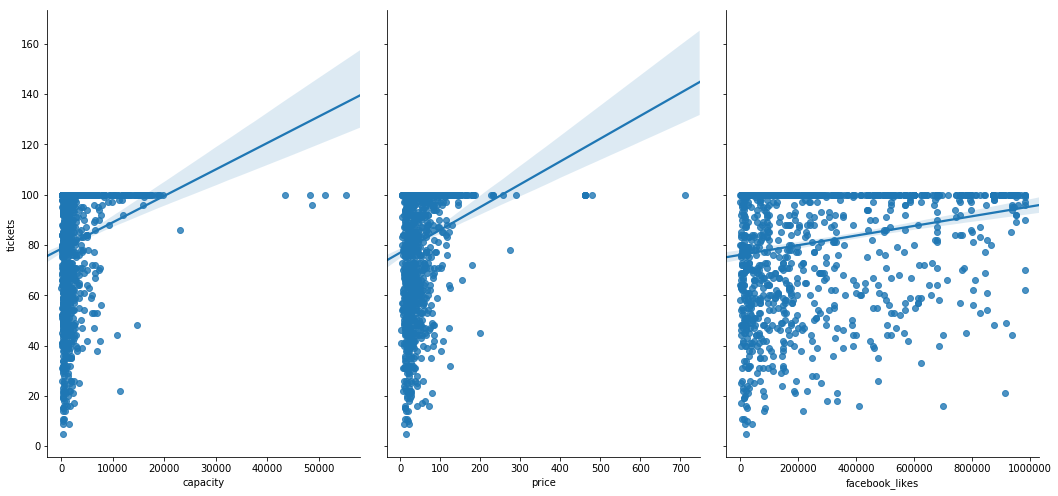

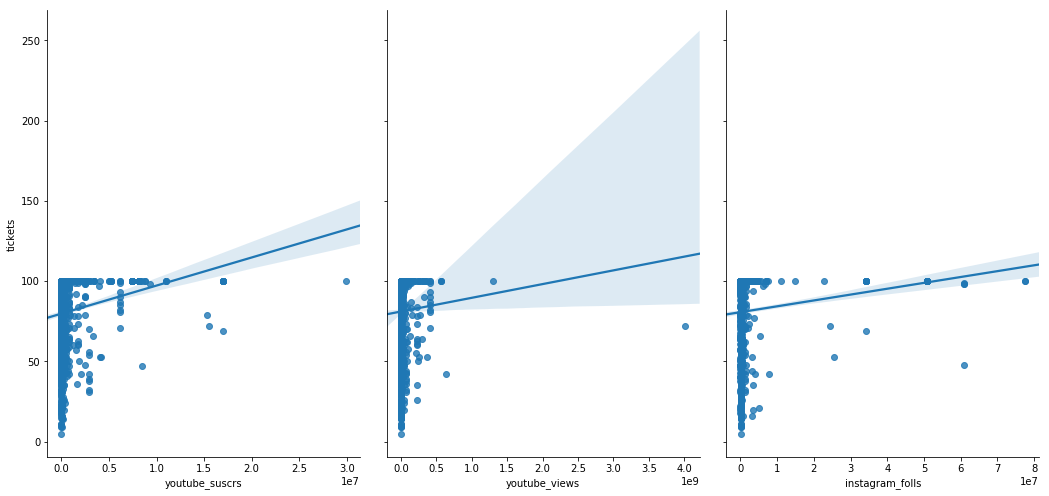

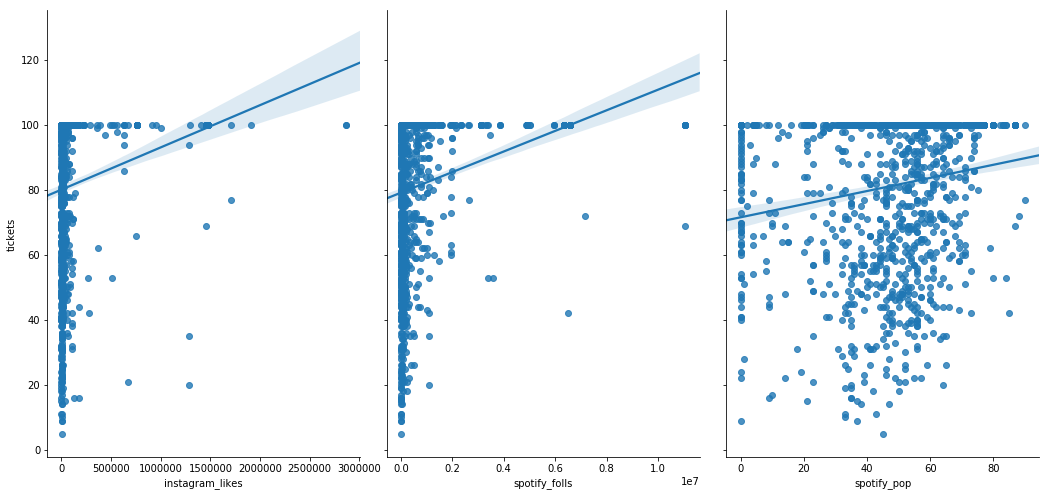

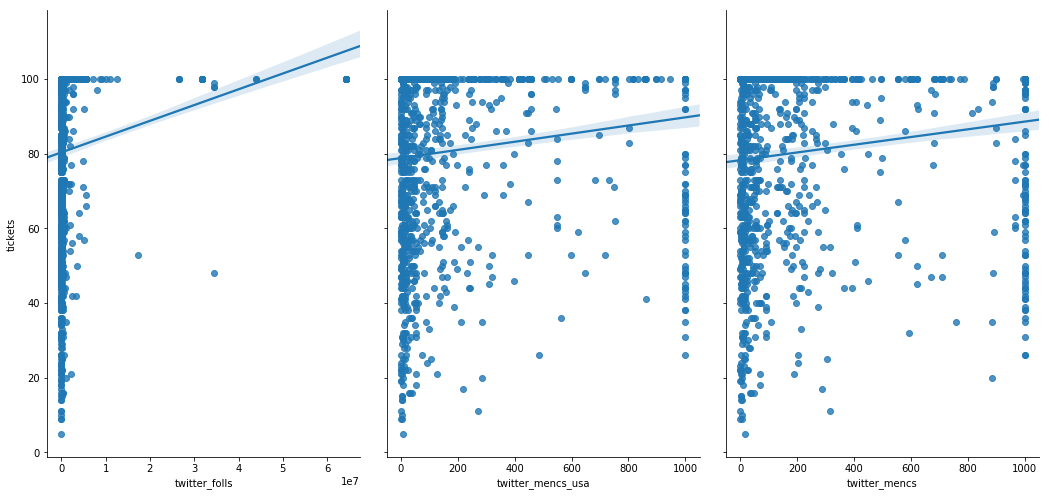

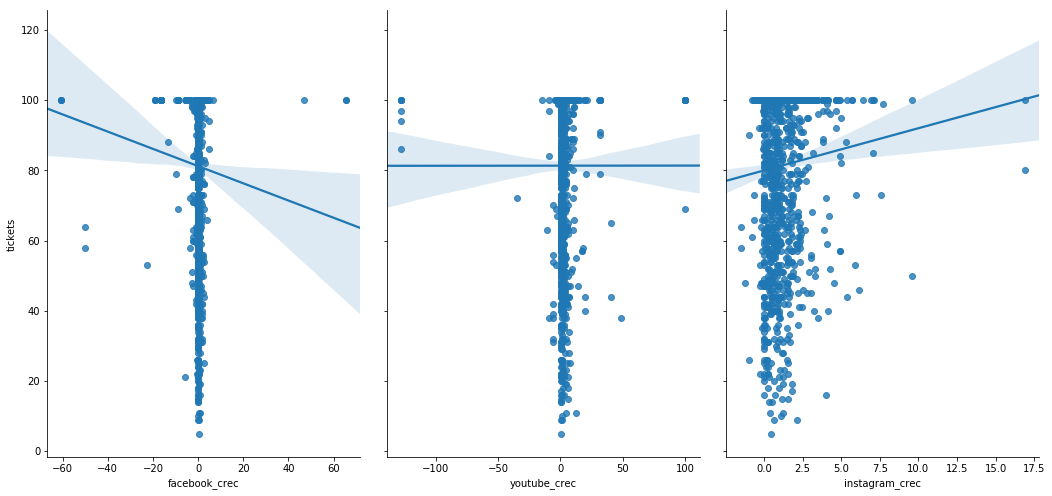

In [5]:
for i in range(8, len(data.columns) - 2, 3):
    sns.pairplot(data, x_vars= [data.columns[i], data.columns[i + 1], data.columns[i + 2]], y_vars='tickets', size=7, aspect=0.7, kind='reg')
    

## 2.2 - Matriz de dispersión

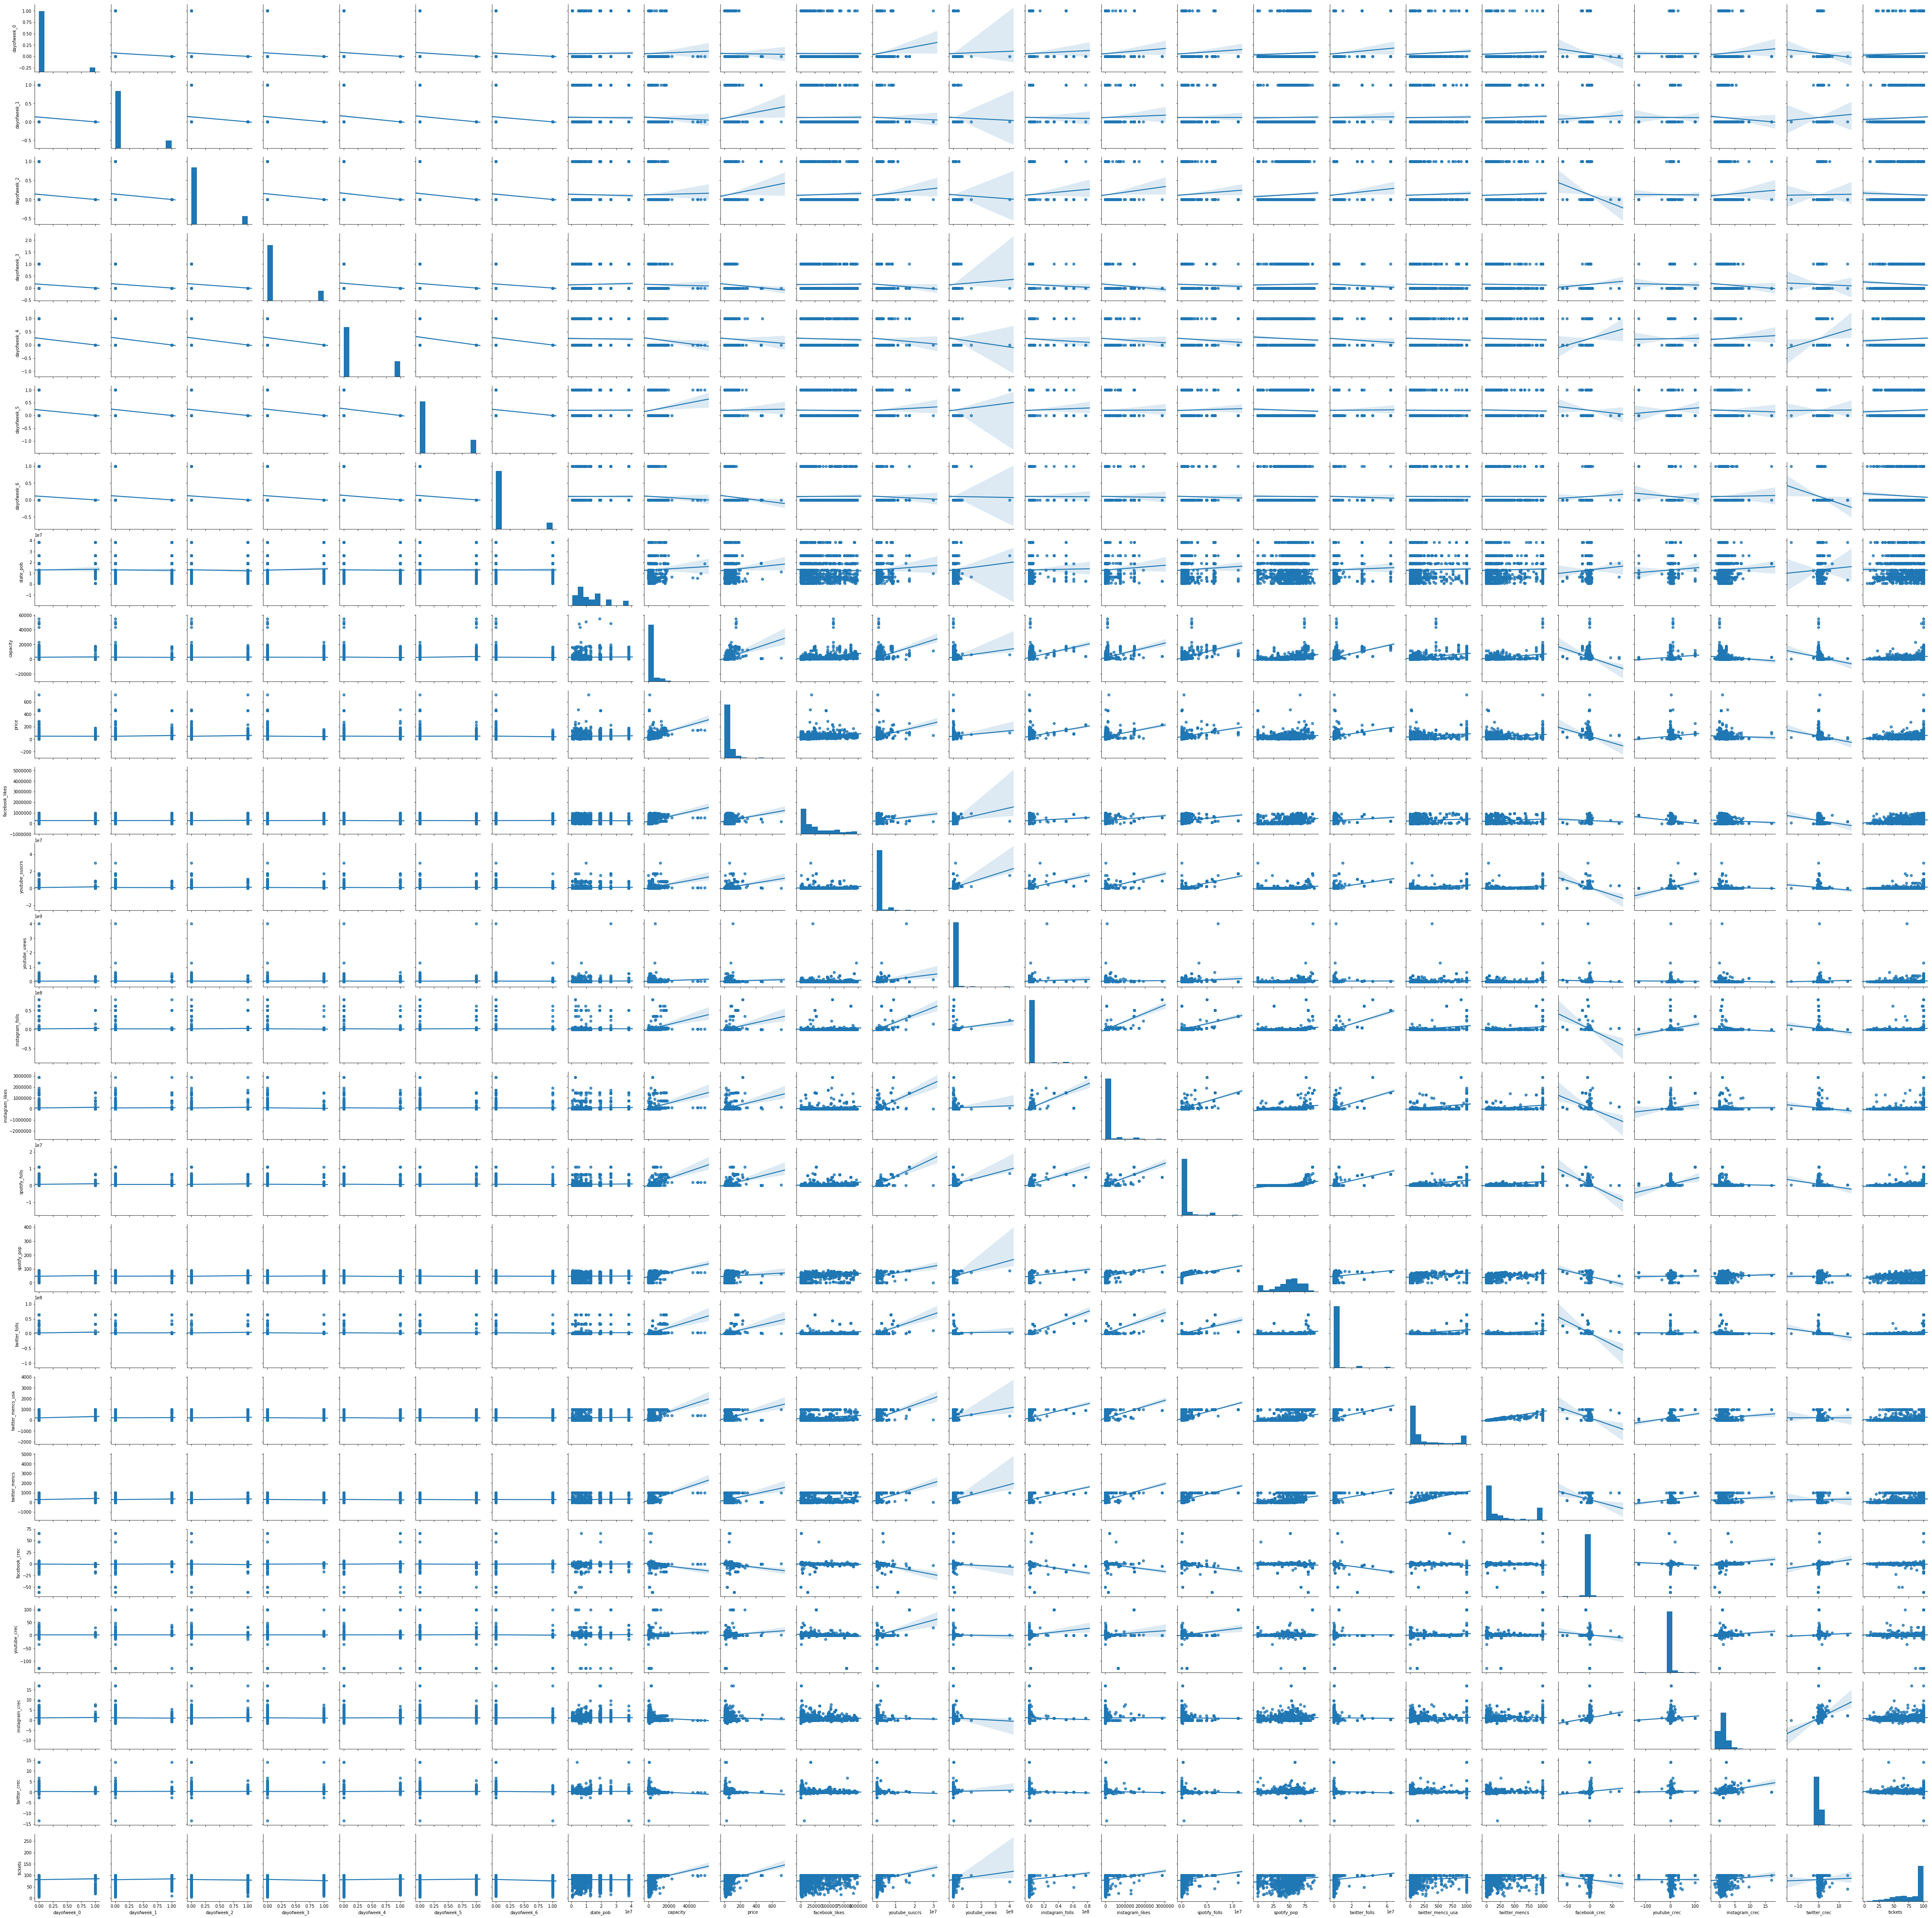

In [6]:
sns.pairplot(data, kind="reg")

## 3.- Evaluaciones de distintos modelos de regresion basados en redes neuronales. (GridSearchCV con k-fold)

### 3.1 - Importaciones

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold
import warnings 
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler 

/opt/conda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 3.2 - Separar conjunto de datos en Matriz de Características y Respuesta (GridSearchCV)

Separeción entre caracteristica y target

In [8]:
nombres_col=list(data.columns)
X = data[nombres_col[0:-1]]
y = data[nombres_col[-1]]

### 3.3 - Busqueda exhaustiva de mejor parámetro

configuración del k-fold

In [9]:
kf = KFold(n_splits=5,shuffle=True)

Escalado

In [10]:
scaler = StandardScaler()

#se aplica el escalado
scaled_X = X.copy(deep = True)
scaled_X[X.columns[6:]] = scaler.fit_transform(scaled_X[scaled_X.columns[6:]])
scaled_X.head()

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,state_pob,capacity,price,...,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec
0,0,0,1,0,0,0,-0.337341,0.573184,-0.388316,-0.306074,...,-0.314077,-0.412396,-2.195375,-0.245641,-0.661419,-0.763188,0.100729,-0.127463,-0.139413,0.350184
1,0,0,0,1,0,0,-0.337341,0.573184,-0.478323,0.143207,...,-0.314077,-0.412396,-2.195375,-0.245641,-0.661419,-0.763188,0.100729,-0.127463,-0.139413,0.350184
2,0,0,0,0,0,0,2.964355,-0.636672,-0.376440,-0.361088,...,-0.192122,1.571890,1.633184,1.096642,0.601425,1.867797,-0.865075,-0.132165,-0.816659,-0.263145
3,0,0,1,0,0,0,-0.337341,-0.642974,-0.279765,0.060686,...,-0.212167,-0.300163,0.402576,-0.236465,-0.519127,-0.625551,0.446458,-0.046069,-0.484206,-0.243394
4,0,0,0,0,1,0,-0.337341,2.501580,-0.366647,-0.718680,...,-0.299862,-0.351905,0.356998,-0.231069,-0.279009,-0.260283,0.123654,-0.091321,-0.462430,-0.167507


Se harán pruebas con:

1 capa oculta y cantidad de neuronas: 90, 120, 150 y 180

funciones de activación: 'identity', 'logistic', 'tanh', 'relu'

metodos de optimización: 'lbfgs', 'sgd', 'adam'

In [11]:
warnings.simplefilter('ignore')
parameters = {'hidden_layer_sizes': [(90,), (120,), (150,), (180,)] , 'activation': ('identity', 'logistic', 'tanh', 'relu'), 'solver': ('lbfgs', 'sgd', 'adam'),'warm_start':[False,True]}


Busqueda exhaustiva

In [12]:
ANN=MLPRegressor(max_iter=100)
clf = GridSearchCV(ANN, parameters, scoring='neg_mean_squared_error', cv = kf)
clf.fit(scaled_X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(90,), (120,), (150,), (180,)], 'activation': ('identity', 'logistic', 'tanh', 'relu'), 'solver': ('lbfgs', 'sgd', 'adam'), 'warm_start': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Mejor parametro encontrado

In [13]:
clf.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (90,),
 'solver': 'sgd',
 'warm_start': False}

In [14]:
MLP= clf.best_estimator_
y_pred=clf.predict(scaled_X)

print ("Error Red Neuronal: ", mean_squared_error(y,y_pred))

Error Red Neuronal:  464.0623017160547


## 4.- Mejor modelo de red neuranal v/s regression lasso

In [20]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
exp_MLP=[]
exp_LR=[]
kf = KFold(n_splits=5,shuffle=True)
for i in range(10):
    resultados_linreg=[]
    resultados_MLP=[]
    X=np.array(X)

   
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        
        #prediccion con regresion
        linreg = Lasso()
        linreg.fit(X_train,y_train)        
        lasso_y_pred = linreg.predict(X_test)
        
        #prediccion con red neuronal        
        scaler = StandardScaler()  
        scaler.fit(X_train)  
        X_train = scaler.transform(X_train)  
        X_test = scaler.transform(X_test)  
        
        mlp_regressor = MLPRegressor(hidden_layer_sizes = (90,), activation = 'logistic', solver = 'sgd', warm_start = False)
        mlp_regressor.fit(X_train,y_train)
        mlp_y_pred=mlp_regressor.predict(X_test)
        
        resultados_linreg.append(mean_squared_error(y_test,lasso_y_pred))
        resultados_MLP.append(mean_squared_error(y_test,mlp_y_pred))
        
    print ("Resultado MLP: ",resultados_MLP)
    print ("Promedio MLP: ",np.mean(resultados_MLP))
    print ("Resultado LinReg: ",resultados_linreg)
    print ("Promedio LinReg: ",np.mean(resultados_linreg))
    
    exp_MLP.append(np.mean(resultados_MLP))
    exp_LR.append(np.mean(resultados_linreg))

Resultado MLP:  [496.9733800206812, 488.04166494268054, 447.1439115685404, 512.7758397747672, 504.7384388894842]
Promedio MLP:  489.93464703923075
Resultado LinReg:  [509.6505645211616, 480.69443156041933, 463.8948778920569, 544.8572614914634, 513.3192447257011]
Promedio LinReg:  502.4832760381604
Resultado MLP:  [587.4191402178319, 524.3503679493747, 477.1758869907775, 399.36436977844534, 518.7527292621982]
Promedio MLP:  501.4124988397255
Resultado LinReg:  [599.865272607275, 530.797867696522, 477.6431891284918, 406.35852938272234, 521.793638002466]
Promedio LinReg:  507.29169936349535
Resultado MLP:  [474.8553610104011, 475.78934859691924, 508.2802476500431, 498.56886704672115, 531.5608328938914]
Promedio MLP:  497.81093143959527
Resultado LinReg:  [478.3806885253465, 487.7534567919618, 503.28426210862824, 515.1944605721808, 540.3455162021344]
Promedio LinReg:  504.99167684005033
Resultado MLP:  [497.9349622985362, 525.1393106982584, 525.3941370219877, 442.4086950485354, 457.0715647

In [21]:
print(exp_MLP)
print(exp_LR)
print("Promedio Experimentos MLP: ", np.mean(exp_MLP),"STD",np.std(exp_MLP))
print("Promedio Experimentos LASSO: ", np.mean(exp_LR),"STD",np.std(exp_LR))

[489.93464703923075, 501.4124988397255, 497.81093143959527, 489.5897339726659, 492.45614719177286, 493.07376402697344, 491.63988475534444, 496.084041933583, 491.433352235273, 490.7651920363305]
[502.4832760381604, 507.29169936349535, 504.99167684005033, 502.3290760756178, 501.7956083346163, 500.39473105073665, 505.0944674981823, 505.02878996859533, 501.77689709844344, 504.69235927776856]
Promedio Experimentos MLP:  493.4200193470494 STD 3.6371490987576536
Promedio Experimentos LASSO:  503.58785815456656 STD 2.018604953428576


### 5.- Test significancia estadistica

In [22]:
from scipy import stats
t2, p2 = stats.ttest_ind(exp_MLP,exp_LR)
print("t = " + str(t2))
print("p = " + str(p2))
if p2<0.05:
    print("We reject the NULL Hypothesis. The differences are statistically significant!")
else:
    print("We cannot reject the NULL Hypothesis. The differences are NOT statistically significant!")

t = -7.332995673906002
p = 8.275060042610949e-07
We reject the NULL Hypothesis. The differences are statistically significant!


### 6.- Correlación salida real v/s la predicha por los modelos

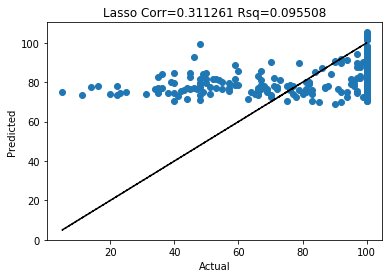

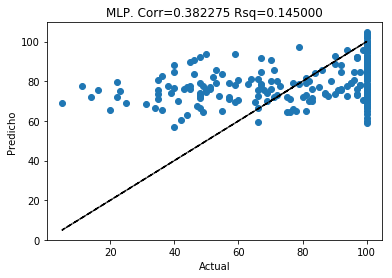

In [23]:
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr

corr_linear = pearsonr(lasso_y_pred,y_test)[0]
rsquared_linear = r2_score(y_test, lasso_y_pred)
plt.scatter(y_test, lasso_y_pred)
plt.title("Lasso Corr=%f Rsq=%f"
% (corr_linear, rsquared_linear))
plt.xlabel("Actual")
plt.ylabel("Predicted")
# add x=y line for comparison
plt.plot(y_test, y_test, 'k--')
plt.show()
corr_MLP = pearsonr(mlp_y_pred,y_test)[0]
rsquared_MLP = round(
r2_score(y_test, mlp_y_pred), 3)
plt.scatter(y_test, mlp_y_pred)
plt.title("MLP. Corr=%f Rsq=%f"
% (corr_MLP, rsquared_MLP))
plt.xlabel("Actual")
plt.ylabel("Predicho")
# add x=y line for comparison
plt.plot(y_test, y_test, 'k--')
plt.show()